---

<h1><center>SDSE Lab 4 <br><br> Time series analysis </center></h1>

---

In [91]:
result = {
    'group_number' : 20  # Enter you group number here
}

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from ts_helper import *
from statsmodels.tsa.filters.filtertools import convolution_filter

In this lab we will also use Pandas, which is a Python package for working with tabular and time series data. Pandas offers two very useful data types: the [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) and the [`Series`](https://pandas.pydata.org/docs/reference/api/pandas.Series.html). We use Pandas only superficially here, and it is capable of a lot more. 

# The dataset

We will analyze data collected at the Mauna Loa Observatory in Hawaii. Due to its high elevation (3,397 meters above sea level) and its remote location in the middle of the Pacific Ocean, the Mauna Loa Observatory is an ideal place for monitoring the health of the atmosphere. The data that we will work with consists of weekly measurements of CO2 concentrations between 1958 and 2001. 

The Mauna Loa dataset is included with the `statsmodels` package. The next cell loads the data into a Pandas `DataFrame` object.

In [93]:
from statsmodels.datasets import co2
df = co2.load_pandas().data


The left column in the table are time stamps, the right column contains the measurements. The time stamps are the index to the `DataFrame`. Notice that their type is `Timestamp`. Pandas `Timestamp`s are a convenient means of working with time series data. They include functionality for converting between units of time, and computing time intervals as the difference between `Timestamp` objects. Also, when plotting a `Series` with index of type `Timestamp`, the labels of the x-axis are automatically formatted.

In [94]:
type(df.index[0])

pandas._libs.tslibs.timestamps.Timestamp

The first step is to plot the data. You can do this either with `matplotlib` as we've done before, or using the `plot` function attached to pandas `DataFrame`s and `Series` objects.

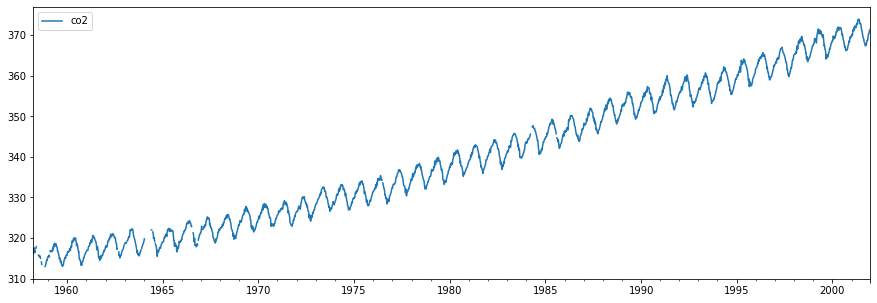

In [95]:
df.plot(figsize=(15,5));

Notice the gaps in the line. These are due to NaN values in the table. If the data were iid, it would make sense to simply discard these rows. However, in this case we cannot do that since we require the sampling rate to remain constant throughout the time series. We will use simple linear interpolation to fill in the missing values. The next cell runs `interpolate` on teh `co2` `Series` and stores the result in a new column called `co2int`.

In [96]:
df['co2int'] = df['co2'].interpolate()
df.head()

,co2,co2int
1958-03-29,316.1,316.1
1958-04-05,317.3,317.3
1958-04-12,317.6,317.6
1958-04-19,317.5,317.5
1958-04-26,316.4,316.4


Notice the following compact syntax for plotting two columns of `df`.

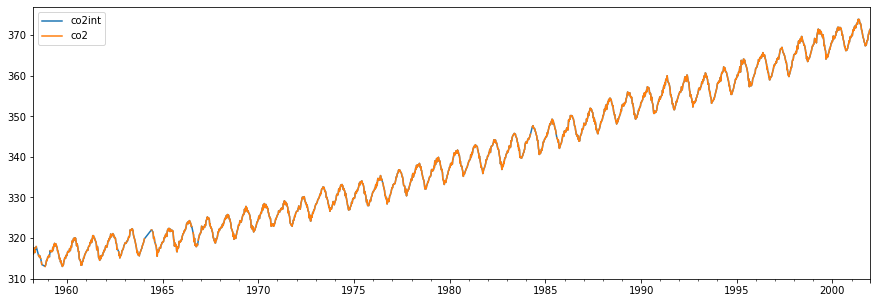

In [97]:
df.plot(figsize=(15,5),y=['co2int','co2']);

# Split data into training and testing 

Next we will select training and testing time series and store them in `y_hist` and `y_future` respectively. `y_hist` should consist of the interpolated measurements up to the end of 1985. `y_future` should contain interpolated measurements from 1986 through the end of 1990. Use Pandas' `loc` method to extract these two series from the `co2int` column of `df`. 

Checks: 
+ `len(y_hist)=1449`
+ `len(y_future)=261`
+ `y_hist` starts on 1958-03-29 and ends on 1985-12-28 
+ `y_future` starts on 1986-01-04 and ends on 1990-12-29

In [98]:
y_hist = df["co2int"].loc[:"1985"]    # this will pick from beginning of dataset to 12-28-1985
y_future = df["co2int"].loc["1986":"1990"]    # this will be from 01-04-1986 to 12-29-1990

print(len(y_hist), len(y_future))
print(y_hist.index[0], y_hist.index[1448],y_future.index[0], y_future.index[260])

1449 261
1958-03-29 00:00:00 1985-12-28 00:00:00 1986-01-04 00:00:00 1990-12-29 00:00:00


In [99]:
################################
# Reporting. Do not modify.#####
result['y_hist'] = y_hist
result['y_future'] = y_future
################################

Create a line plot showing both historical (training) and forecast (testing) datasets. Notice that matplotlib's `plot` function can infer the x-axis values from the the indexes of the two `Series` object. 

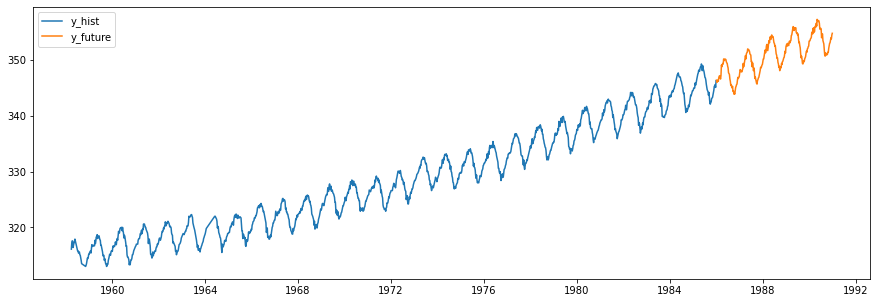

In [100]:
fig1 = plt.figure(figsize=(15,5));
plt.plot(y_hist);
plt.plot(y_future);
plt.legend(['y_hist','y_future']);

In [101]:
################################
# Reporting. Do not modify.#####
result['fig1'] = fig1
################################

# Extract the trend

The sampling period of the data is weekly. From the previous graph we note that there is a clear periodicity of one solar year, or 52.18 weeks, or 525,949 minutes. This is the true period of the data, however we also need an integer number of samples for the period, which we choose to be 52. Below we define these two values; the true period and the rounded period.


In [102]:
minute_per_year = 525_949 # true period in minutes
round_period = 52  # rounded period in # samples = # weeks


To extract the trend we will smooth `y_hist` with a convolution kernel with length equal to the period length. 

Build a convolution kernel with the following properties:
+ It should be a numpy array with shape (53,1).
+ Its sum should equal 1. 
+ All values should be positive. 
+ All of its values should be equal, except the first and the last whose value should be one half of the others. 

In [103]:
kernel  = np.ones(round_period+1) 
l = len(kernel)
gamma = 1/(l-1)
kernel[1:l-1] = gamma
kernel[0] = kernel[-1] = gamma/2
kernel = np.array([kernel]).transpose()


In [104]:
################################
# Reporting. Do not modify.#####
result['kernel'] = kernel
################################

The following code runs the convolution kernel over `y_hist` and then fills the two ends of the time series by extrapolation.

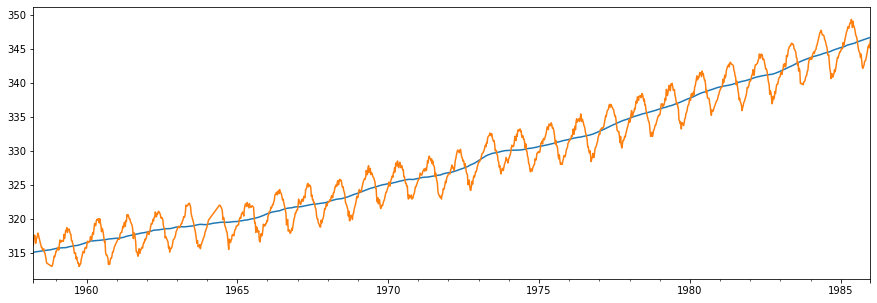

In [105]:
nsides = 2
trend = convolution_filter(y_hist, kernel, 2)
trend = extrapolate_trend(trend, round_period + 1)

plt.figure(figsize=(15,5))
trend.plot()
y_hist.plot();

# Detrend the data

Compute the detrended time series by subtracting the trend from `y_hist`. Plot the result.

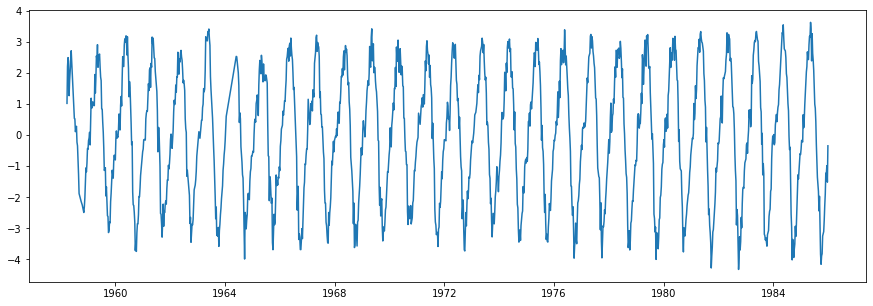

In [106]:
detrended = y_hist-trend  

fig2 = plt.figure(figsize=(15,5))
plt.plot(detrended);

In [107]:
################################
# Reporting. Do not modify.#####
result['fig2'] = fig2
################################

# Extract the seasonal component

Next we split the historical data into yearly periods. For ease of prediction, we place the boundary of the last period on the last data point in `y_hist`. Then, each period begins some integer number of years before 1985-12-28. Here we need to account for the fact that the true period is not an integer number of samples. 

The following code computes the indices of the boundaries between periods. 

In [108]:
delta = y_hist.index - y_hist.index[-1]
mod = np.mod(delta.days*24*60, minute_per_year)
split_ind = np.where(np.diff(mod)<0)[0] + 1
split_ind = split_ind[:-1]

# Remove the portion of `y_hist`, `trend`, and `detrended` prior to the beginning of the first period. 
y_hist = y_hist[split_ind[0]:]
trend = trend[split_ind[0]:]
detrended = detrended[split_ind[0]:]
split_ind -= split_ind[0]

In [109]:
print(split_ind)

[   0   52  104  156  208  261  313  365  417  469  521  574  626  678
  730  782  835  887  939  991 1043 1095 1148 1200 1252 1304 1356]


Plot the detrended data as before and overlay it with vertical line (`plt.axvline`) at the boundaries defined in `split_ind`.

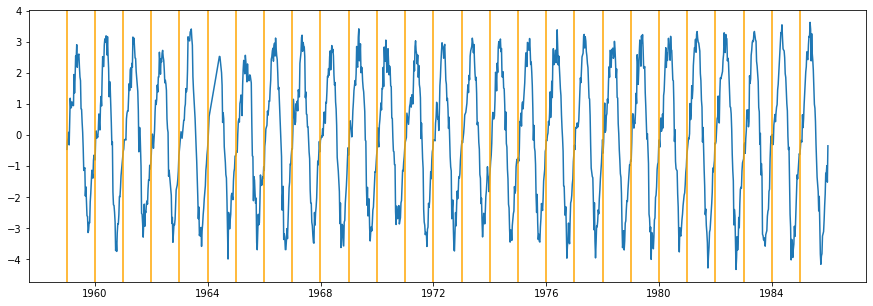

In [110]:
fig3 = plt.figure(figsize=(15,5))
plt.plot(detrended)
for i in split_ind:
    plt.axvline(y_hist.index[i],color="orange")

In [111]:
################################
# Reporting. Do not modify.#####
result['fig3'] = fig3
################################

Create a matrix (ie a 2D numpy array) with `round_period` columns and one row for every period. Populate each row with the first `round_period` values in each period. 

In [112]:
all_periods = np.zeros((len(split_ind),round_period))
# ADD CODE HERE
for i in range(len(split_ind)):
    for j in range(round_period):
        row = split_ind[i]
        all_periods[i,j] = detrended[row+j]

print(all_periods.shape)

(27, 52)


In [113]:
################################
# Reporting. Do not modify.#####
result['all_periods'] = all_periods
################################

Compute the average period profile and store it as `all_periods_avg`. The shape of `all_periods_avg` should be `(52,)`.

Create a plot with the following elements:
+ All rows of `all_periods` plotted in a single plot. All should be plotted in black and with `linewidth=0.3`.
+ The average profile in magenta with `linewidth=4`. 

(52,)


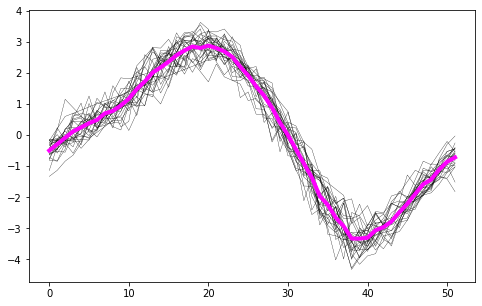

In [114]:
all_periods_avg = all_periods.mean(axis=0) # mean down the rows
print(all_periods_avg.shape)

fig4 = plt.figure(figsize=(8,5))
for i in range(all_periods.shape[0]):
        plt.plot(all_periods[i,:],linewidth = 0.3,color = "black");
plt.plot(all_periods_avg, linewidth = 4, color = "magenta");

In [115]:
################################
# Reporting. Do not modify.#####
result['fig4'] = fig4
################################

# Model the historical data

Construct the model for the historical data.
1. Create a `Series` object called `y_hist_model` with index equal to `y_hist.index`. (Done already)
2. For each period, set the first `round_period` values in that period to `all_periods_avg`. 
3. Add in the trend.
4. Fill in gaps left by leap years using linear interpolation.

Plot the result along with `y_hist`. 

In [116]:
y_hist_model = pd.Series(index=y_hist.index,data=np.NaN)#step 1

for ind in split_ind:
    y_hist_model[ind:ind+round_period] = all_periods_avg #step 2

y_hist_model = y_hist_model + trend #step 3
y_hist_model.interpolate() #step 4
print(y_hist_model)

1959-01-03    315.159972
1959-01-10    315.382051
1959-01-17    315.610862
1959-01-24    315.830950
1959-01-31    315.963860
                 ...    
1985-11-30    345.096690
1985-12-07    345.443776
1985-12-14    345.727911
1985-12-21    345.897018
1985-12-28           NaN
Freq: W-SAT, Length: 1409, dtype: float64


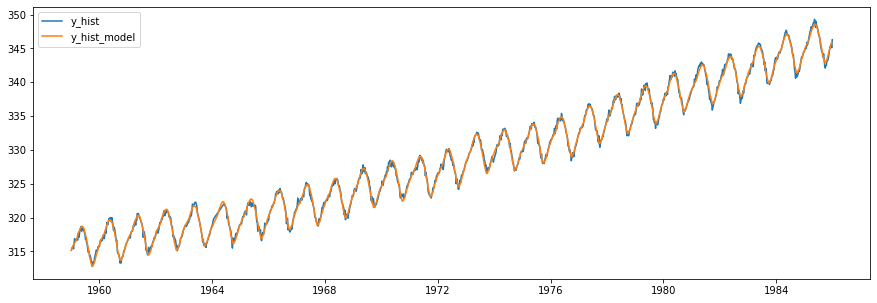

In [117]:
fig5 = plt.figure(figsize=(15,5))
plt.plot(y_hist);
plt.plot(y_hist_model);
plt.legend(['y_hist','y_hist_model']);


In [118]:
################################
# Reporting. Do not modify.#####
result['y_hist_model'] = y_hist_model
result['fig5'] = fig5
################################

Compute the residue by subtracting the model from the `y_hist`

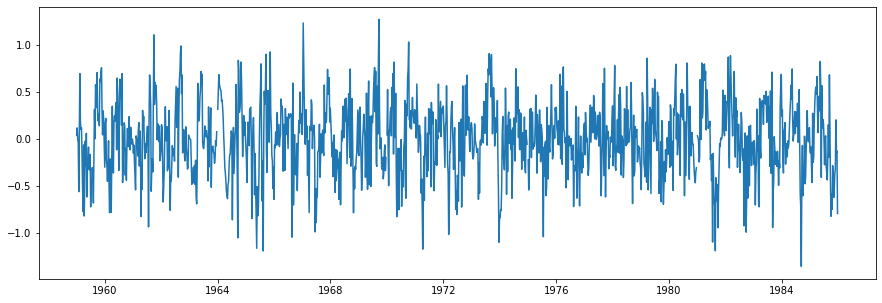

In [119]:
residue = y_hist - y_hist_model 
fig = plt.figure(figsize=(15,5))
plt.plot(residue);

In [120]:
################################
# Reporting. Do not modify.#####
result['residue'] = residue
################################

# Prediction 

1. Use Python's `//` operator to compute the integer number of 52-week years in `y_future`. Call this value `num_future_years`.
2. Discard the samples in `y_future` that go beyond `num_future_seasons*round_period`. 

Hint: After doing this, `len(y_future)` should equal 260.


In [124]:
num_future_years = len(y_future)//52 #step 1
y_future = y_future[:num_future_years*round_period]
len(y_future)

260

In [125]:
################################
# Reporting. Do not modify.#####
result['y_future'] = y_future
################################

Compute the average slope of the trend in the last two years of the historical period. Call this `avg_slope`. This slope is then used to construct `future_trend` as the linear extrapolation of the trend (done already)

In [138]:
avg_slope = np.mean(trend[-2*len(split_ind)*round_period:].diff()) # ADD CODE HERE
future_trend = pd.Series(index=y_future.index, 
                         data= trend[-1] + range(1,len(y_future)+1)*avg_slope )

In [140]:
print(avg_slope)

0.022008284901177545


In [139]:
################################
# Reporting. Do not modify.#####
result['avg_slope'] = avg_slope
################################

Compute the prediction by adding the seasonal component to `future_trend`. Save this as `y_predict`. 

Hint: `np.tile()`

Plot the following in a single plot:
+ the final two years of `y_hist` and `trend`
+ `y_future`
+ `future_trend`
+ `y_predict`

Make sure that `trend` extends smoothly into `future_trend`.

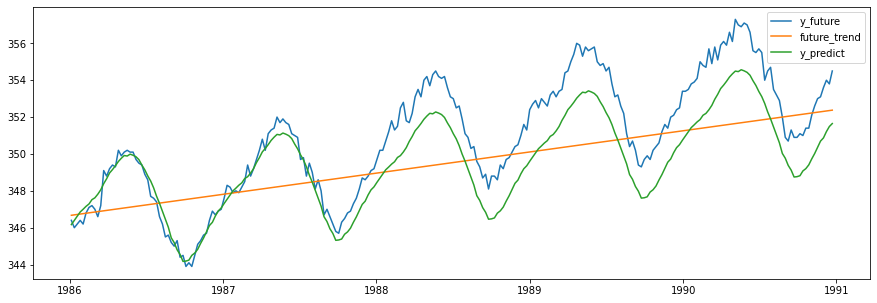

In [145]:

y_predict_data = future_trend + np.tile(all_periods_avg,num_future_years) #step 1

y_predict = pd.Series(index=y_future.index, data=y_predict_data)

fig6 = plt.figure(figsize=(15,5))
plt.plot(y_future);
plt.plot(future_trend);
plt.plot(y_predict);
plt.legend(['y_future','future_trend','y_predict']);

In [ ]:
################################
# Reporting. Do not modify.#####
result['fig6'] = fig6
################################

Plot the residuals and prediction errors as time series, and on the same plot (but with different colors).

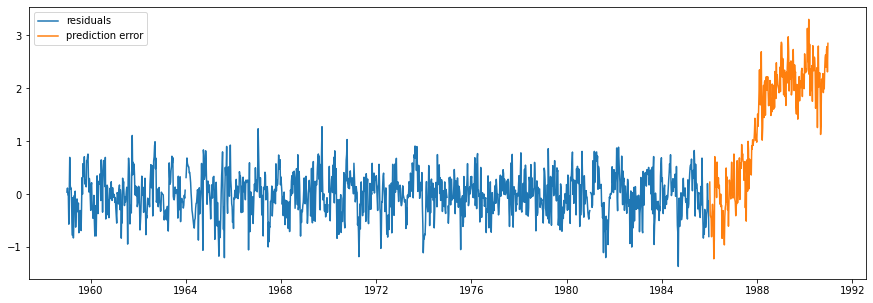

In [147]:
predict_error = (y_future - y_predict)
fig7 = plt.figure(figsize=(15,5))
plt.plot(residue);
plt.plot(predict_error);
plt.legend(['residuals','prediction error']);



In [148]:
################################
# Reporting. Do not modify.#####
result['fig7'] = fig7
################################

Comment on the strengths and weaknesses of this approach to modeling relative to other time series techniques. 

In [150]:
comment = 'The decomposition approach requires relatively less data than other techniques and interpretation of the model is intuitive, helping you understand patterns in the overall data. Some weaknesses include the lack of modeling of short term variability, and that the length of cycles need to be known apriori or guessed by the user' 

In [151]:
################################
# Reporting. Do not modify.#####
result['comment'] = comment
################################

---
## Do not modify below this

In [152]:
with open('group_{}.pickle'.format(result['group_number']),'wb') as file:
    pickle.dump(result,file)